# Term Deposit Prediction

## Introduction

In this project, we will develop a classification model to help identify potential subscribers to a term deposit. Such a model will help save a great amount of time at call centers and allow banks to market their term deposits to more worthwhile clients. To accomplish this, we will first preprocess our data, perform exploratory data analysis to uncover key insights into what makes a worthwhile client, and then we will train and tune our model, optimzing for precision to minimize the number of false positives.

## Our Data

Our data is a csv file from a call center with the following data dictionary:

 - **age** : age of customer (numeric)

 - **job** : type of job (categorical)

 - **marital** : marital status (categorical)

 - **education** (categorical)

 - **default**: has credit in default? (binary)

 - **balance**: average yearly balance, in euros (numeric)

 - **housing**: has a housing loan? (binary)

 - **loan**: has personal loan? (binary)

 - **contact**: contact communication type (categorical)

 - **day**: last contact day of the month (numeric)

 - **month**: last contact month of year (categorical)

 - **duration**: last contact duration, in seconds (numeric)

 - **campaign**: number of contacts performed during this campaign and for this client (numeric, includes last contact)

 - **y**: has the client subscribed to a term deposit? (our target binary variable)


## Preprocessing

First, let us inspect our dataset.

In [ ]:
!pip install imblearn # our libary for handling imbalanced data
!pip install pingouin # our library for statistical testing
!pip install shap # our library for SHAP values

In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, RobustScaler, SplineTransformer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE

data = pd.read_csv('/content/term-deposit-marketing-2020.csv')

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [ ]:
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

In [ ]:
data.duplicated().sum()

0

In [ ]:
categorical_cols = [col for col in data.columns if data[col].dtype == 'object']
numerical_cols = [col for col in data.columns if data[col].dtype != 'object']

for col in categorical_cols:
  print(f'{col}: {data[col].unique()}')

job: ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital: ['married' 'single' 'divorced']
education: ['tertiary' 'secondary' 'unknown' 'primary']
default: ['no' 'yes']
housing: ['yes' 'no']
loan: ['no' 'yes']
contact: ['unknown' 'cellular' 'telephone']
month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr']
y: ['no' 'yes']


In [ ]:
data[numerical_cols].describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


From the results above, we see that our data has no duplicates nor missing values. All of the strings in the categorical columns are properly formatted. However, the binary categorical columns (yes/no as entries) will need to be label encoded. The columns 'job', 'education', and 'contact' have the entry 'unknown' which will not help our model learn meaningful patterns. And moreover, we see that many of the numeric columns like `balance`, `duration`, and `campaign` are heavily right skew because the mean is far larger than the median. So let us define a helper function to label encode the binary categorical columns, and let us create new numeric features which we will later use in our model.

In [ ]:
def wragle(df):

  df_clean = df.copy()

  # label encoding
  label_enc_cols = [
      'y',
      'default',
      'loan',
      'housing'
  ]
  label_enc_map = {
      'yes': 1,
      'no': 0
  }
  month_map = {
      'jan': 1,
      'feb': 2,
      'mar': 3,
      'apr': 4,
      'may': 5,
      'jun': 6,
      'jul': 7,
      'aug': 8,
      'sep': 9,
      'oct': 10,
      'nov': 11,
      'dec': 12
  }
  for col in label_enc_cols:
    df_clean[col] = df_clean[col].map(label_enc_map)

  df_clean['month'] = df_clean['month'].map(month_map)

  # create new datetime feature
  df_clean['date'] = pd.to_datetime(
      '2020-' + df_clean['month'].astype(str) + '-' + df_clean['day'].astype(str)
  )
  # sort by new datetime feature
  df_clean = df_clean.sort_values(by='date').reset_index(drop=True)

  # rename target column
  df_clean.rename(columns={'y': 'subscribed'}, inplace=True)

  # new cols
  df_clean['balance_to_call_ratio'] = df_clean['balance'] / df_clean['campaign']
  df_clean['avg_total_time'] = df_clean['duration']*df_clean['campaign']
  df_clean['total_time_by_date'] = df_clean.groupby('date')['duration'].transform('sum')
  df_clean['avg_total_time_by_date'] = df_clean.groupby('date')['avg_total_time'].transform('mean')
  df_clean['balance_to_call_ratio_by_date'] = df_clean.groupby('date')['balance_to_call_ratio'].transform('mean')
  df_clean['avg_total_time_by_date'] = df_clean.groupby('date')['avg_total_time'].transform('mean')
  df_clean['cum_duration'] = df_clean['duration'].cumsum()
  df_clean['cum_calls'] = df_clean['campaign'].cumsum()

  # remove unknowns
  mask_edu = df_clean['education'] != 'unknown'
  mask_job = df_clean['job'] != 'unknown'
  mask_contact = df_clean['contact'] != 'unknown'
  mask_all = (mask_edu) & (mask_job) & (mask_contact)
  df_clean = df_clean[mask_all]

  return df_clean.reset_index(drop=True)

data_clean = wragle(data)
data_clean.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,campaign,subscribed,date,balance_to_call_ratio,avg_total_time,total_time_by_date,avg_total_time_by_date,balance_to_call_ratio_by_date,cum_duration,cum_calls
0,59,management,married,tertiary,0,2143,1,0,cellular,28,...,1,0,2020-01-28,2143.0,59,104366,421.703046,623.981218,59,1
1,33,technician,single,tertiary,0,0,0,0,cellular,28,...,2,0,2020-01-28,0.0,466,104366,421.703046,623.981218,292,3
2,53,management,married,tertiary,0,0,0,0,cellular,28,...,2,0,2020-01-28,0.0,3490,104366,421.703046,623.981218,2037,5
3,58,technician,married,secondary,0,1,0,0,cellular,28,...,2,0,2020-01-28,0.5,1072,104366,421.703046,623.981218,2573,7
4,43,blue-collar,married,secondary,0,1035,0,0,cellular,28,...,1,0,2020-01-28,1035.0,122,104366,421.703046,623.981218,2695,8


In [ ]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26295 entries, 0 to 26294
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   age                            26295 non-null  int64         
 1   job                            26295 non-null  object        
 2   marital                        26295 non-null  object        
 3   education                      26295 non-null  object        
 4   default                        26295 non-null  int64         
 5   balance                        26295 non-null  int64         
 6   housing                        26295 non-null  int64         
 7   loan                           26295 non-null  int64         
 8   contact                        26295 non-null  object        
 9   day                            26295 non-null  int64         
 10  month                          26295 non-null  int64         
 11  duration       

Now that we have preprocessed our data, let us move on to exploratory data analysis.

## Exploratory Data Analysis

First, let us define several helper functions that will make our analysis smoother and easier.

In [ ]:
num_cols = [
    'age',
    'balance',
    'duration',
    'campaign',
    'balance_to_call_ratio',
    'avg_total_time',
    'total_time_by_date',
    'avg_total_time_by_date',
    'balance_to_call_ratio_by_date',
    'cum_duration',
    'cum_calls'
]

colors = sns.color_palette('pastel')

def plot_hist_and_box(df, col, color):
  """
  Plots a histogram and a boxplot for a numerical column
  Args:
    df: pandas.DataFrame
    col: str
    color: str
  """
  fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw=dict(height_ratios=[0.15, 0.85]))
  sns.boxplot(x=col, data=df, ax=axs[0], showmeans=True, color=color)
  if df[col].nunique() > 50:
    sns.histplot(x=col, data=df, ax=axs[1], color=color)
  else:
    sns.histplot(x=col, data=df, ax=axs[1], color=color, bins=15)
  axs[1].axvline(df[col].mean(), color='green', linestyle='--')
  axs[1].axvline(df[col].median(), color='red', linestyle='--')
  axs[0].set(
      title=f"Distribution of {col}",
      xlabel=None,
      ylabel=None,
      xticks=[],
      yticks=[]
  )
  axs[1].set(
      xlabel="",
      ylabel=f"Count"
  )
  axs[1].annotate(
      f"""
      Mean: {df[col].mean():.2f}
      Median: {df[col].median():.2f}
      Min: {df[col].min():.2f}
      Max: {df[col].max():.2f}
      Standard Deviation: {df[col].std():.2f}
      Skewness: {df[col].skew():.2f}
      """,
      xy=(0.95, 0.95),
      xycoords="axes fraction",
      ha="right",
      va="top",
      fontsize=12,
      fontweight='bold',
      color='black'
  )
  plt.show()
  plt.clf()

def plot_text(bar_plot_axes, horizontal = False):
  """
  Adds texts annotations to a bar plot
  Args:
    bar_plot_axes: matplotlib.axes._subplots.AxesSubplot
    horizontal: bool
  if horizontal, the bars are plotted horizontally
  else, the bars are plotted vertically
  """
  if horizontal:
    for patch in bar_plot_axes.patches:
      bar_plot_axes.annotate(
          f"{(patch.get_width()):.0f}",
          (patch.get_width() + 10, patch.get_y() + patch.get_height() / 2),
          xytext=(0, 0),
          textcoords="offset points",
          ha="center",
          va="center",
          fontsize=12,
          fontweight='bold'
      )
  else:
    for patch in bar_plot_axes.patches:
      bar_plot_axes.annotate(
          f"{(patch.get_height()):.0f}",
          (patch.get_x() + patch.get_width() / 2, patch.get_height() + 10),
          xytext=(0, 0),
          textcoords="offset points",
          ha="center",
          va="center",
          fontsize=12,
          fontweight='bold'
      )


def plot_bar(df, col, color):
  """
  Plots a bar plot for a categorical column
  Args:
    df: pandas.DataFrame
    col: str
    color: str
  If the number of categories is less than 5, then the bars are plotted horizontally.
  Otherwise, the bars are plotted vertically.
  """
  sorted_counts = df[col].value_counts().sort_values(ascending=False)
  plt.figure(figsize=(10, 6))
  if df[col].nunique() < 5:
    horizontal = False
    ax = sns.countplot(
          x=col,
          data=df,
          order=sorted_counts.index,
          palette='pastel'
      )
  else:
    horizontal = True
    ax = sns.barplot(
          x=sorted_counts.values,
          y=sorted_counts.index,
          palette='pastel',
          orient='h'
      )
  plot_text(ax, horizontal)
  ax.set_title(f"Distribution of {col}")
  plt.show()
  plt.clf()

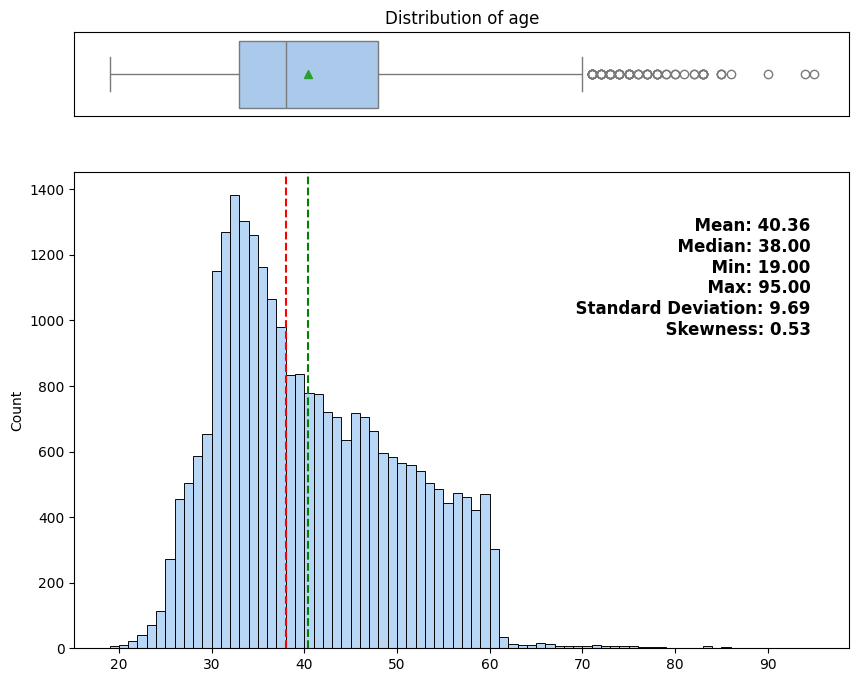

<Figure size 640x480 with 0 Axes>

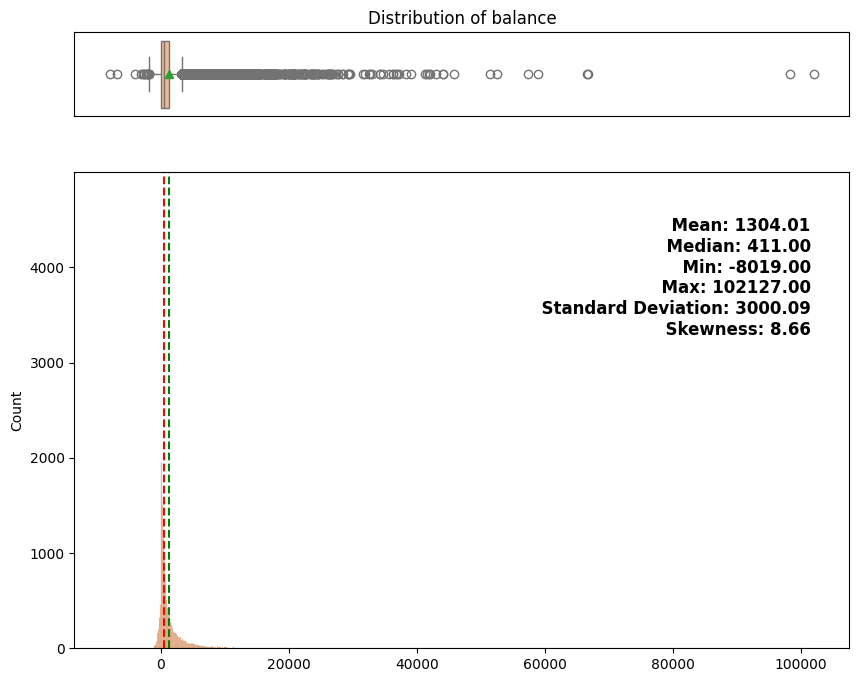

<Figure size 640x480 with 0 Axes>

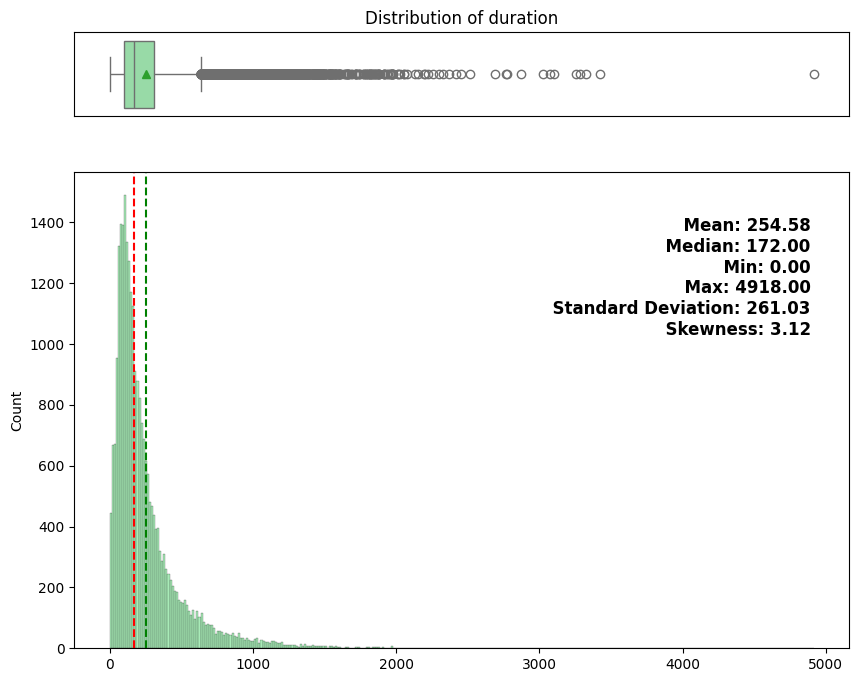

<Figure size 640x480 with 0 Axes>

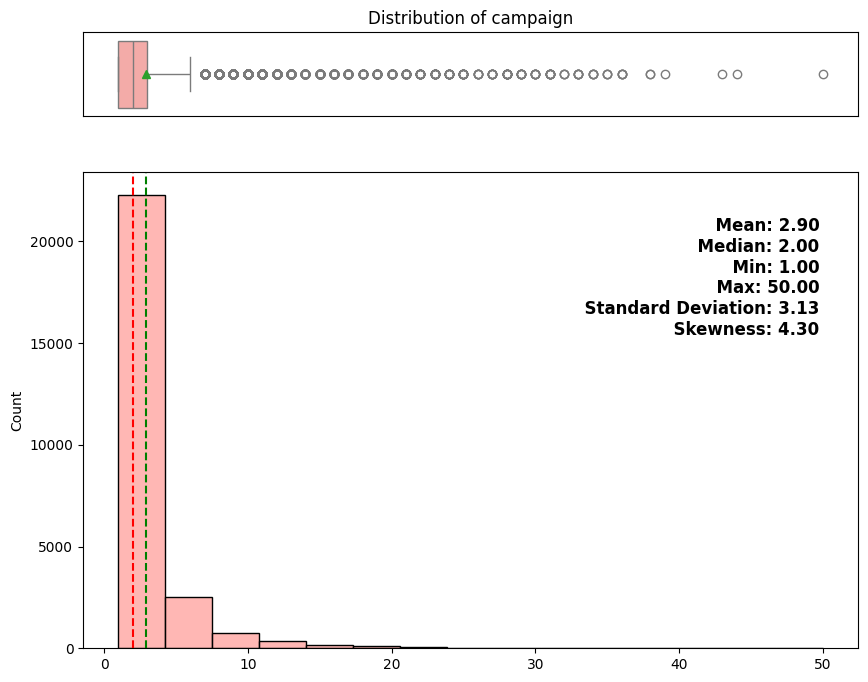

<Figure size 640x480 with 0 Axes>

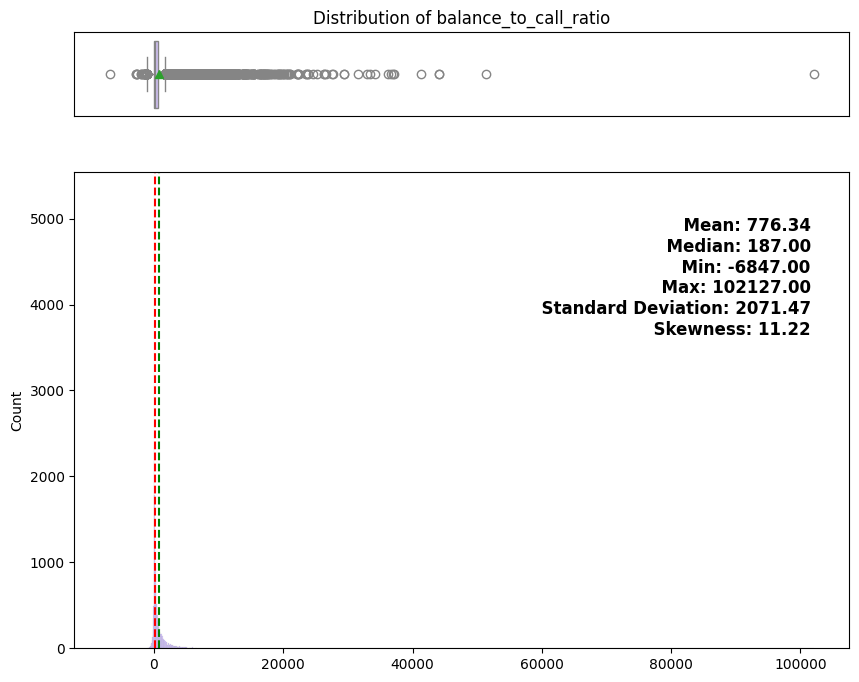

<Figure size 640x480 with 0 Axes>

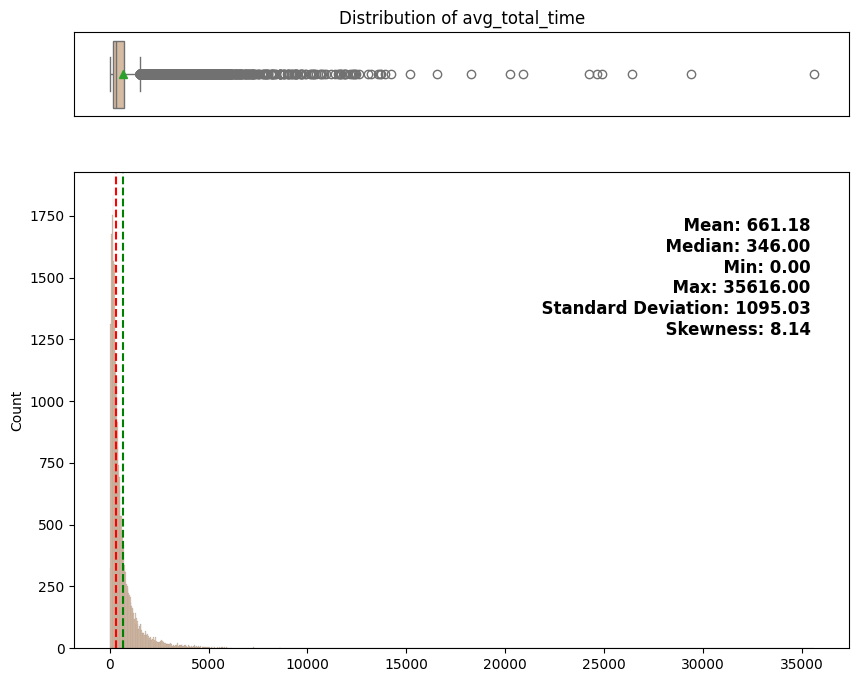

<Figure size 640x480 with 0 Axes>

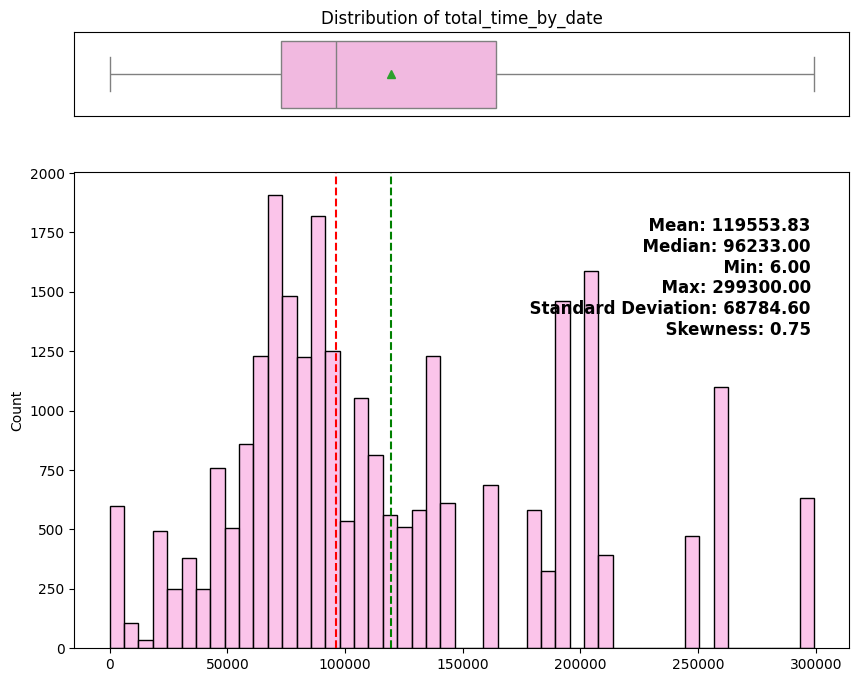

<Figure size 640x480 with 0 Axes>

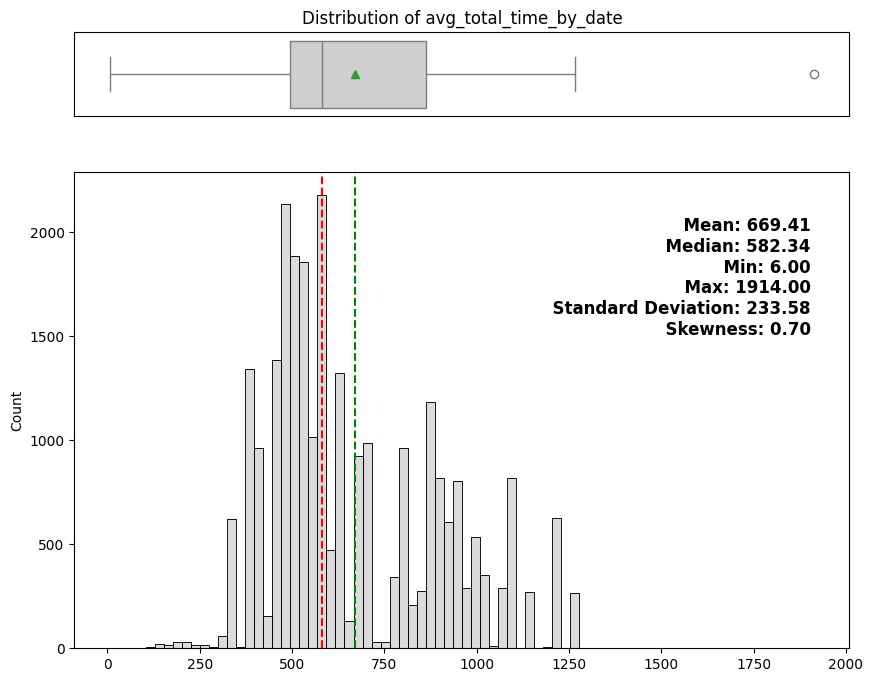

<Figure size 640x480 with 0 Axes>

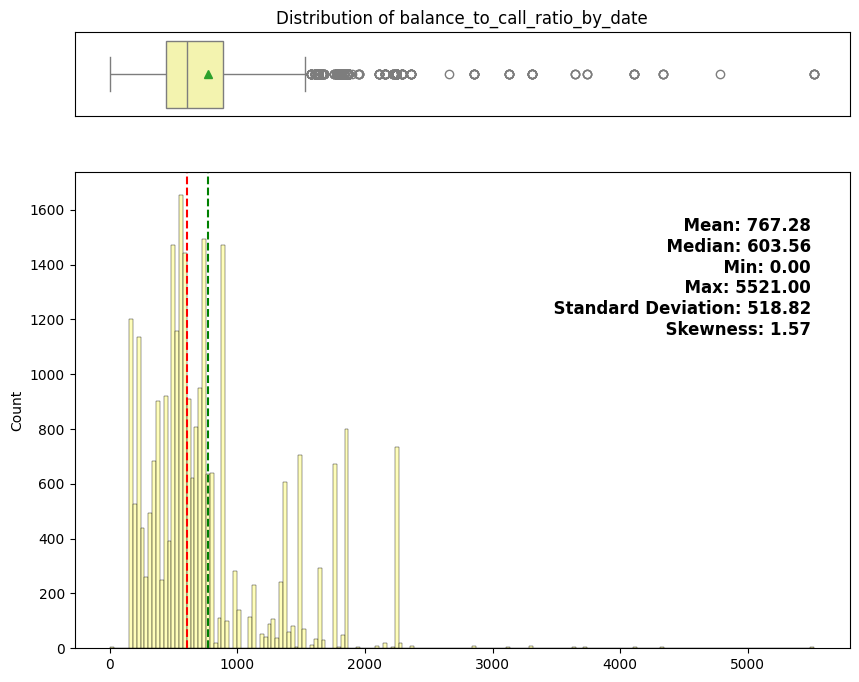

<Figure size 640x480 with 0 Axes>

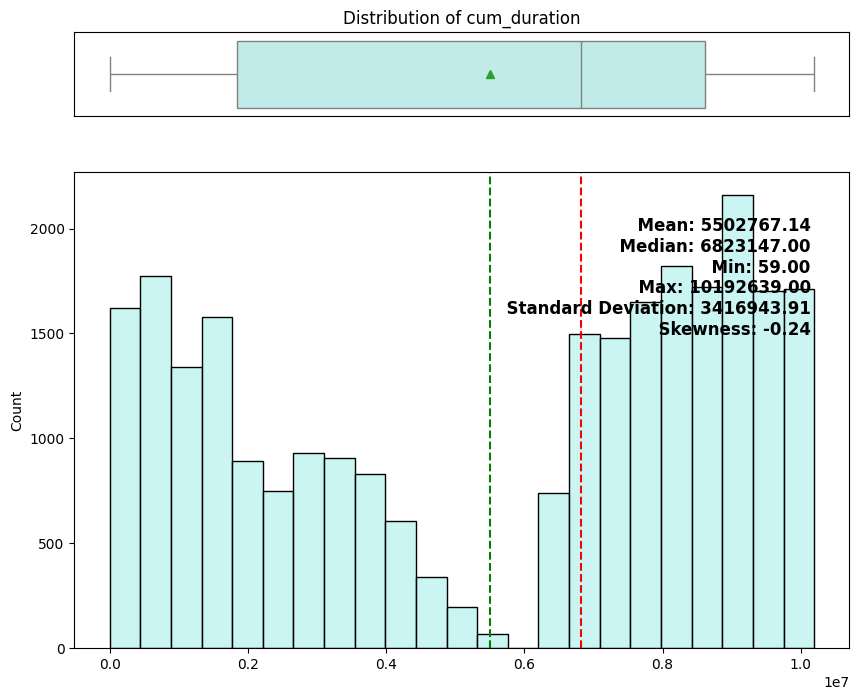

<Figure size 640x480 with 0 Axes>

In [ ]:
for col, color in zip(num_cols, colors):
  plot_hist_and_box(data_clean, col, color)

From the plots above, we see that most of our numeric features are highly skewed and are on different scales. Later, we will apply the yeo-johnson transformation, along with the robust scaler, to normalize and standardize them.

Now let's investigate the distribution of our categorical features.

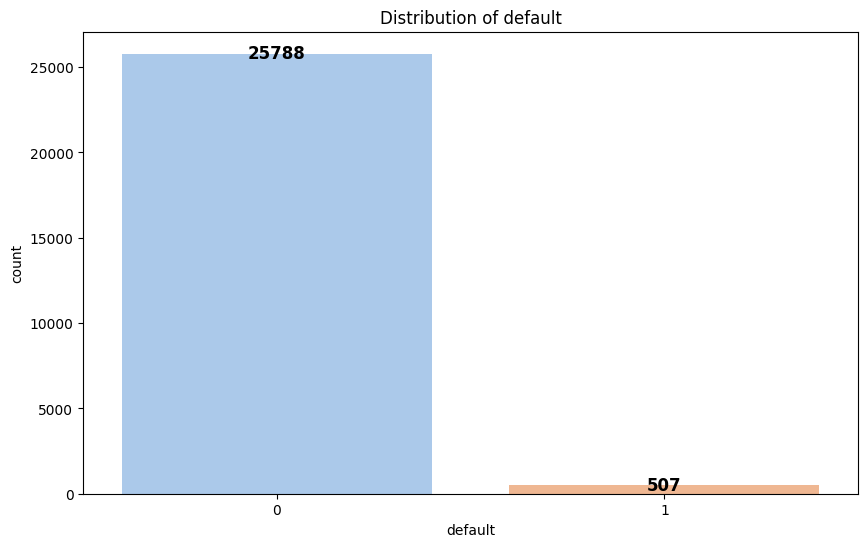

<Figure size 640x480 with 0 Axes>

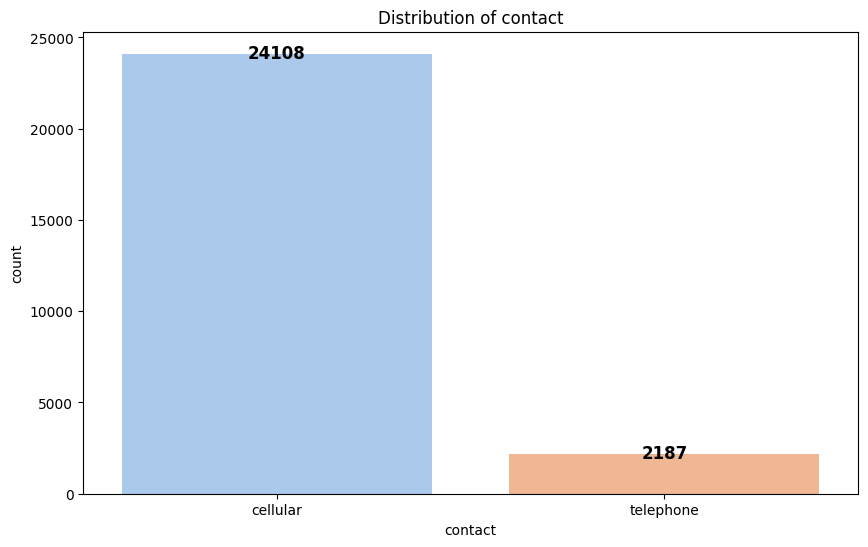

<Figure size 640x480 with 0 Axes>

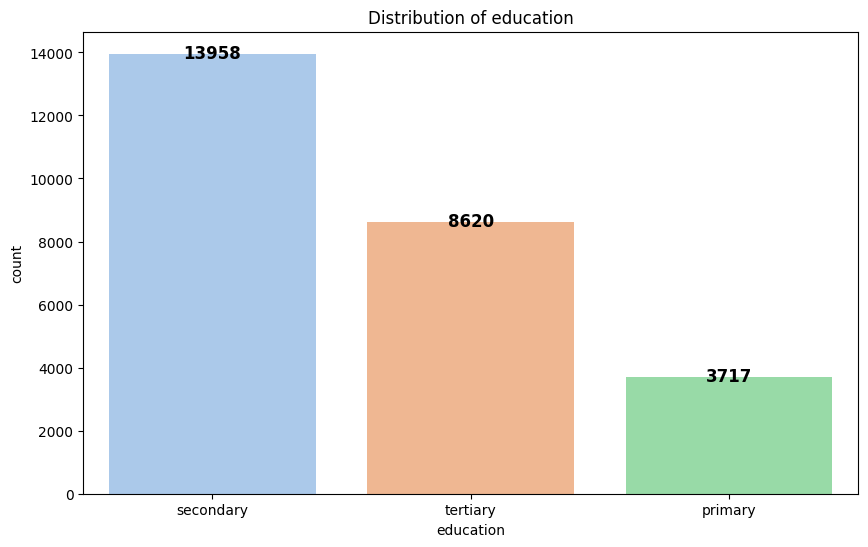

<Figure size 640x480 with 0 Axes>

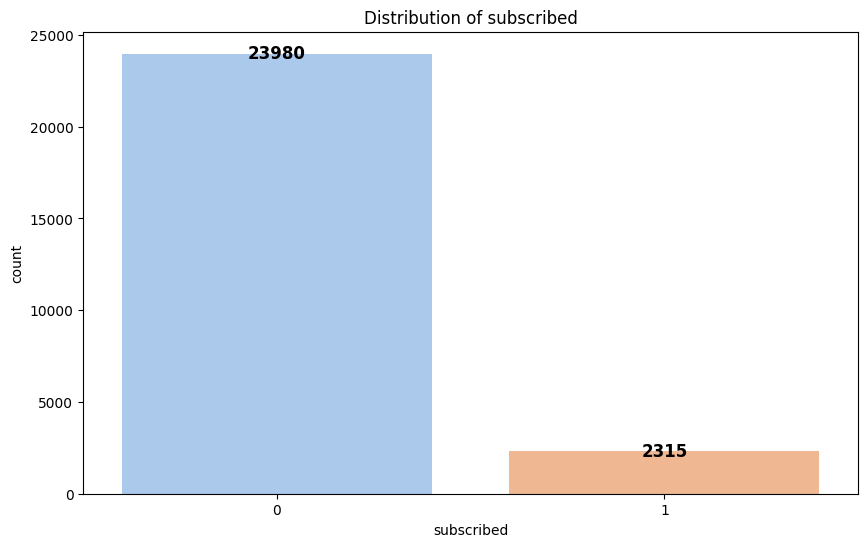

<Figure size 640x480 with 0 Axes>

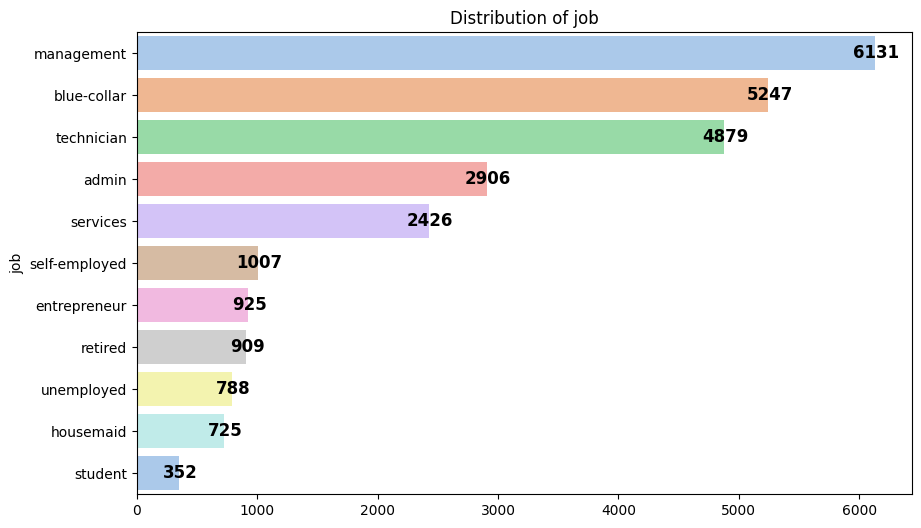

<Figure size 640x480 with 0 Axes>

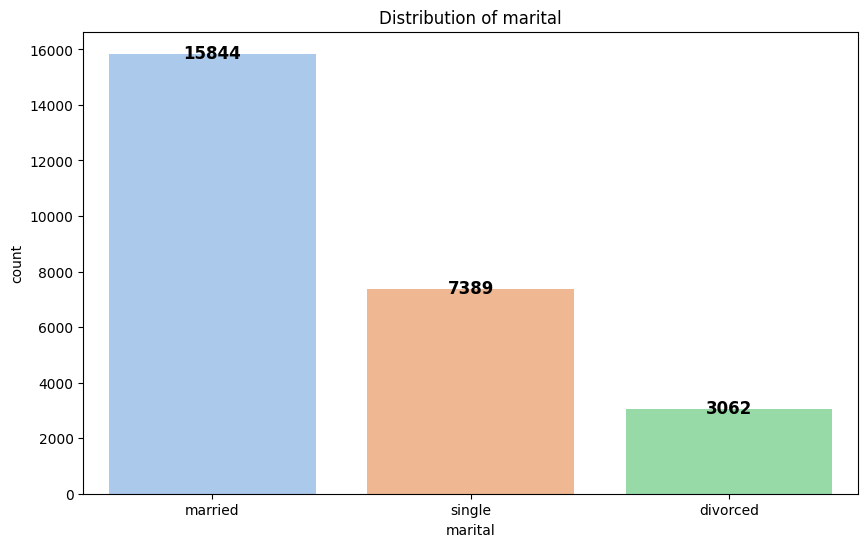

<Figure size 640x480 with 0 Axes>

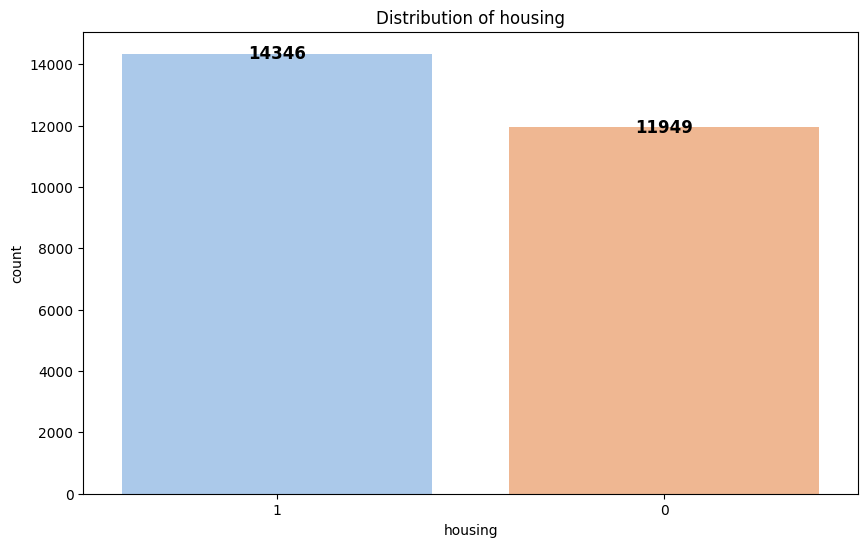

<Figure size 640x480 with 0 Axes>

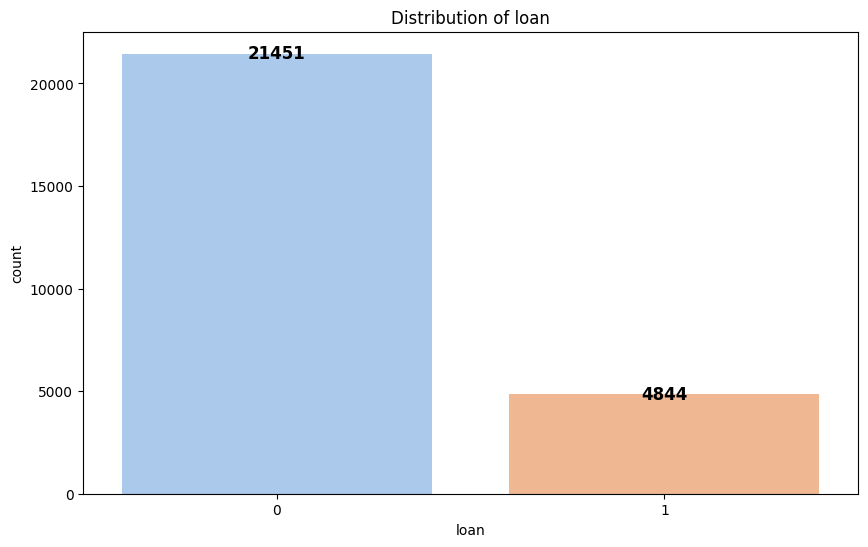

<Figure size 640x480 with 0 Axes>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

cat_cols = list(
    set(data_clean.columns) - set(num_cols) - set(['date', 'day', 'month'])
)

for col, color in zip(cat_cols, colors):
  plot_bar(data_clean, col, color)

From the plots above, we see that our classes are severely imbalanced. To address this, we will use SMOTE (Synthetic Minority Oversampling Technique) to oversample the minority class.

Now that are univariate analysis is complete, let us investigate the relationship between our target variable and the other features.

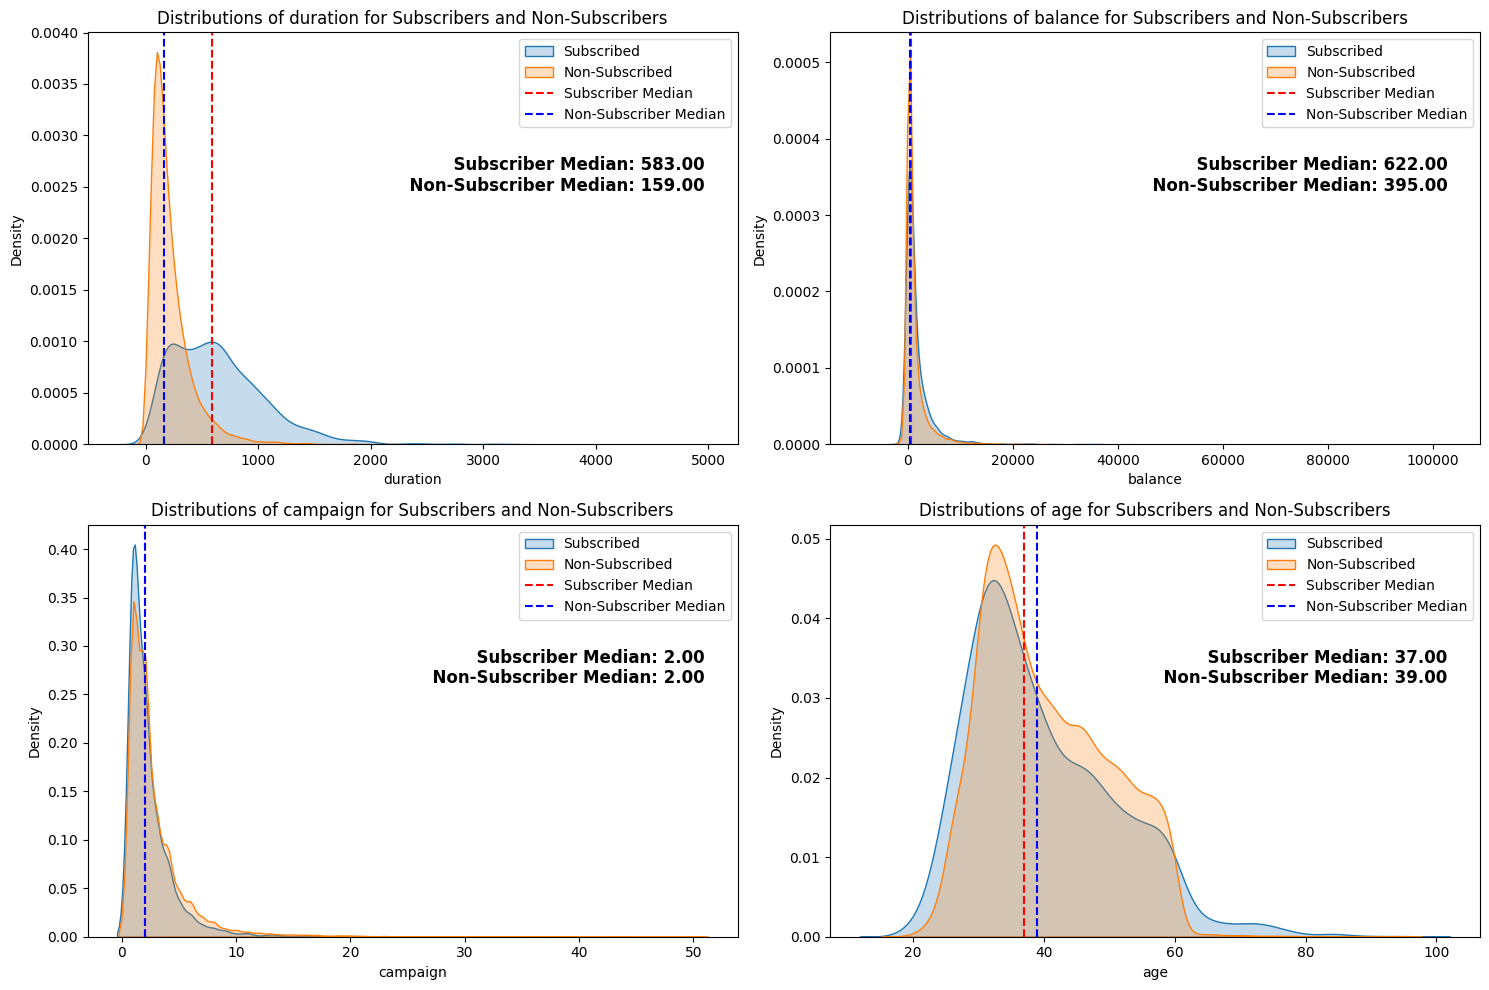

In [ ]:
subscribers = data_clean[data_clean['subscribed'] == 1][num_cols]
non_subscribers = data_clean[data_clean['subscribed'] == 0][num_cols]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize= (15, 10))

for i, col in enumerate(['duration', 'balance', 'campaign', 'age']):
  sns.kdeplot(
      subscribers[col],
      label='Subscribed',
      shade=True,
      ax=axs[i // 2, i % 2]
  )
  sns.kdeplot(
      non_subscribers[col],
      label='Non-Subscribed',
      shade=True,
      ax=axs[i // 2, i % 2]
  )
  axs[i // 2, i % 2].set(
      title=f"Distributions of {col} for Subscribers and Non-Subscribers",
  )
  axs[i // 2, i % 2].axvline(
      subscribers[col].median(),
      color='red',
      linestyle='--',
      label='Subscriber Median'
  )
  axs[i // 2, i % 2].axvline(
      non_subscribers[col].median(),
      color='blue',
      linestyle='--',
      label='Non-Subscriber Median'
  )
  axs[i // 2, i % 2].annotate(
      f"""
      Subscriber Median: {subscribers[col].median():.2f}
      Non-Subscriber Median: {non_subscribers[col].median():.2f}
      """,
      xy=(0.95, 0.75),
      xycoords='axes fraction',
      ha='right',
      va='top',
      fontsize=12,
      fontweight='bold'
  )
  axs[i // 2, i % 2].legend()

plt.tight_layout()
plt.show()

From the plots above we see that there is a gap between the median duration and balance for subscribers and non subscribers. For subscribers, both are much higher.

So let us apply the Mann Whitney U test to see if the difference is statistically significant.

In [ ]:
!pip install pingouin

In [ ]:
import pingouin as pg

# mwu test for duration
results_duration = pg.mwu(
    subscribers['duration'],
    non_subscribers['duration'],
    alternative='greater'
)

# mwu test for balance
results_balance = pg.mwu(
    subscribers['balance'],
    non_subscribers['balance'],
    alternative='greater'
)

print(f"p-val for duration: {results_duration['p-val'].values[0]}")
print(f"p-val for balance: {results_balance['p-val'].values[0]}")

p-val for duration: 0.0
p-val for balance: 5.548878861557925e-25


We see that our p-values our significant, and we reject the null hypothesis for both tests. This suggests that median duration and balance for subscribers is higher than for non-subscribers.

Now let's investigate the subscriber counts faceted by each of our categorical columns.

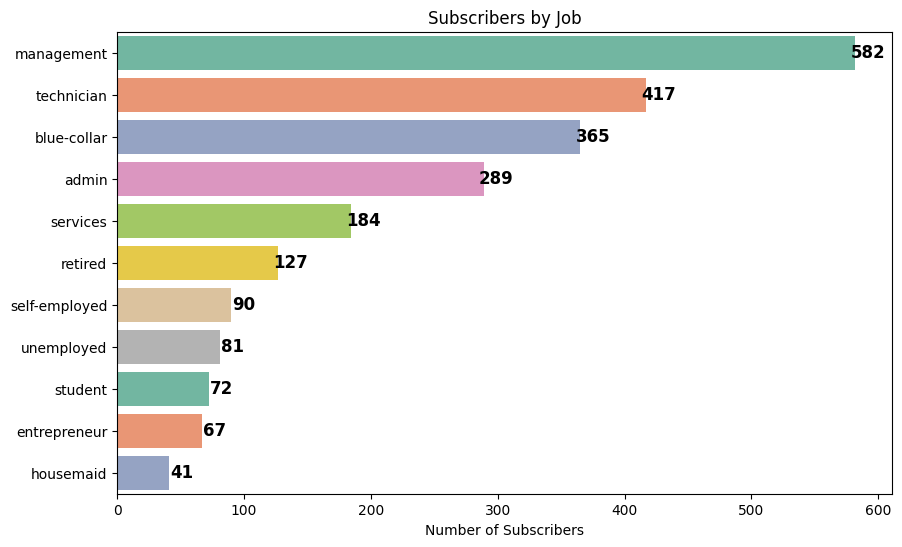

In [ ]:
subscribers_by_job = data_clean.groupby('job')['subscribed'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
      y=subscribers_by_job.index,
      x=subscribers_by_job.values,
      palette='Set2',
      orient='h'
  )
plot_text(ax, horizontal=True)
ax.set(
      title='Subscribers by Job',
      xlabel='Number of Subscribers',
      ylabel=None
  )
plt.show()

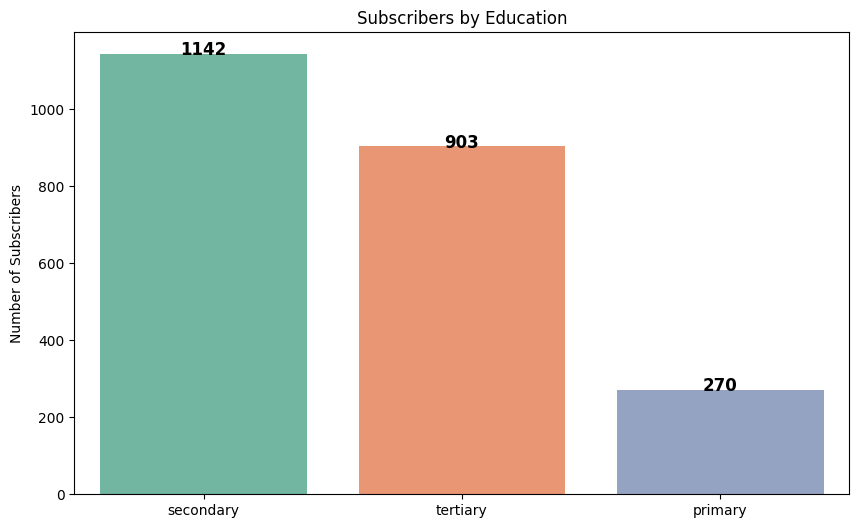

In [ ]:
subscribers_by_education = data_clean.groupby('education')['subscribed'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
      x=subscribers_by_education.index,
      y=subscribers_by_education.values,
      palette='Set2',
  )
plot_text(ax, horizontal=False)
ax.set(
      title='Subscribers by Education',
      ylabel='Number of Subscribers',
      xlabel=None
  )
plt.show()

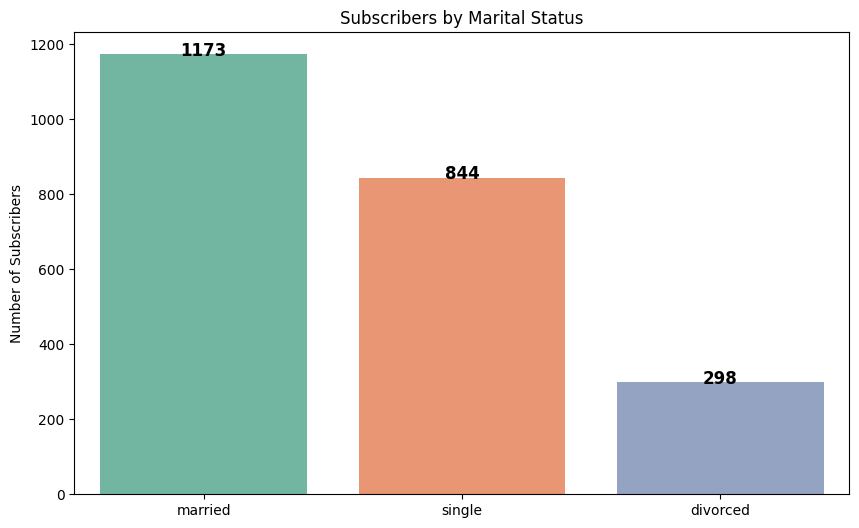

In [ ]:
subscribers_by_marital_status = data_clean.groupby('marital')['subscribed'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
      x=subscribers_by_marital_status.index,
      y=subscribers_by_marital_status.values,
      palette='Set2',
  )
plot_text(ax, horizontal=False)
ax.set(
      title='Subscribers by Marital Status',
      ylabel='Number of Subscribers',
      xlabel=None
  )
plt.show()

From the plots above, we see that married people with higher income jobs and at least a secondary education make up the majority of subscribers.

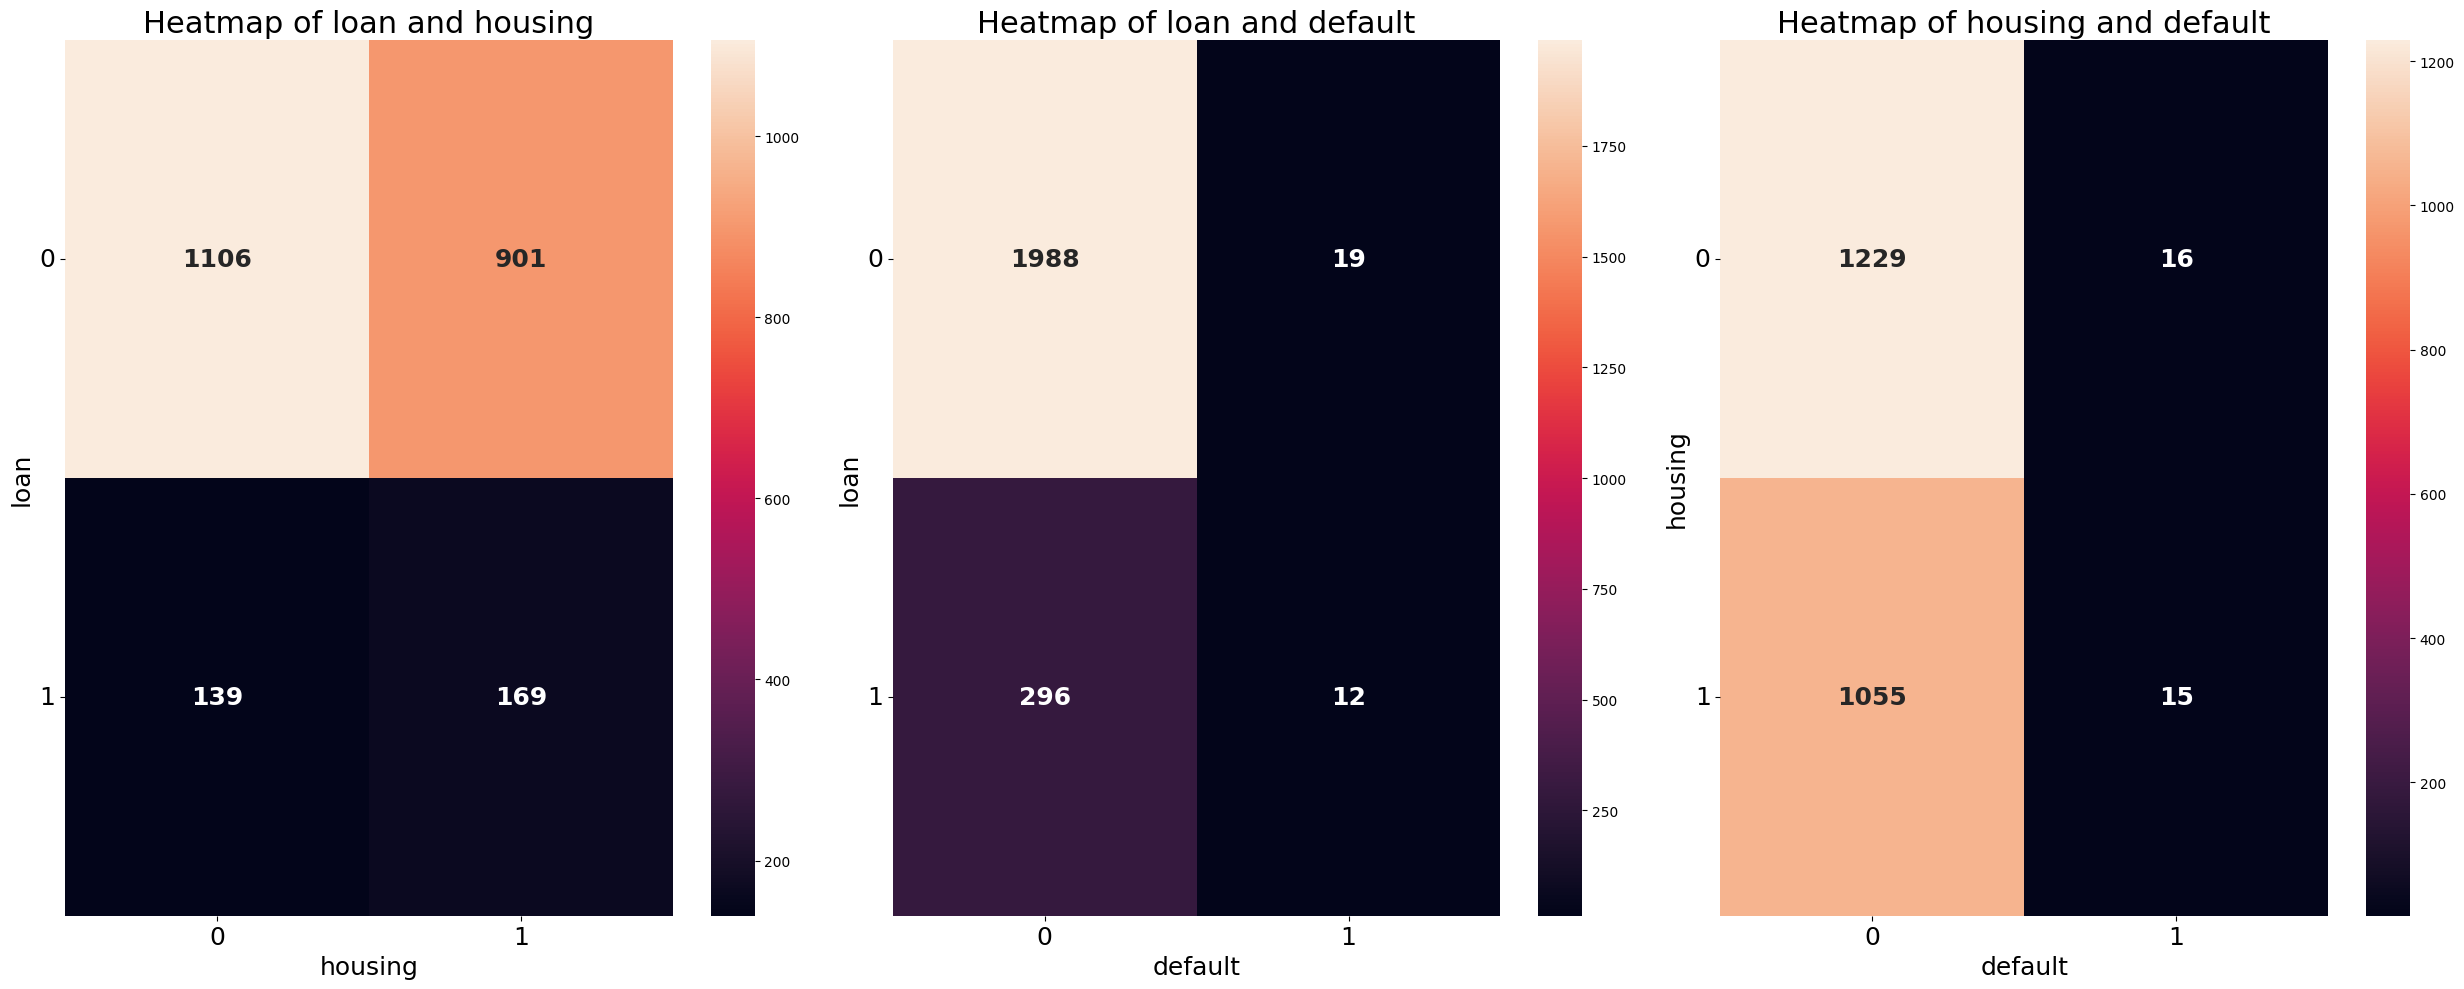

In [ ]:
from itertools import combinations

cols = [
    'loan',
    'housing',
    'default'
]

cat_pairs = list(combinations(cols, 2))

crosstabs = {
    pair: pd.crosstab(
        data_clean[pair[0]],
        data_clean[pair[1]],
        values=data_clean['subscribed'],
        aggfunc='sum'
    )
    for pair in cat_pairs
}

fig, axs = plt.subplots(nrows=1, ncols=len(crosstabs), figsize=(25, 10))

for i, (pair, crosstab) in enumerate(crosstabs.items()):
  sns.heatmap(
      crosstab,
      annot=True,
      fmt='d',
      ax=axs[i],
      annot_kws={
          'fontsize': 18,
          'fontweight': 'bold'
      }
  )
  axs[i].set_title(f"Heatmap of {pair[0]} and {pair[1]}", fontsize=22)
  axs[i].set_xlabel(pair[1], fontsize=18)
  axs[i].set_ylabel(pair[0], fontsize=18)
  axs[i].tick_params(labelsize=18)
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=0, fontsize=18)
  axs[i].set_yticklabels(axs[i].get_yticklabels(), rotation=0, fontsize=18)


plt.tight_layout()
plt.show()

From the plots above, we see that people with no loans make up the majority of subscribers. This further suggests that ideal clients for term deposits have disposable income to invest, along with a good credit history.

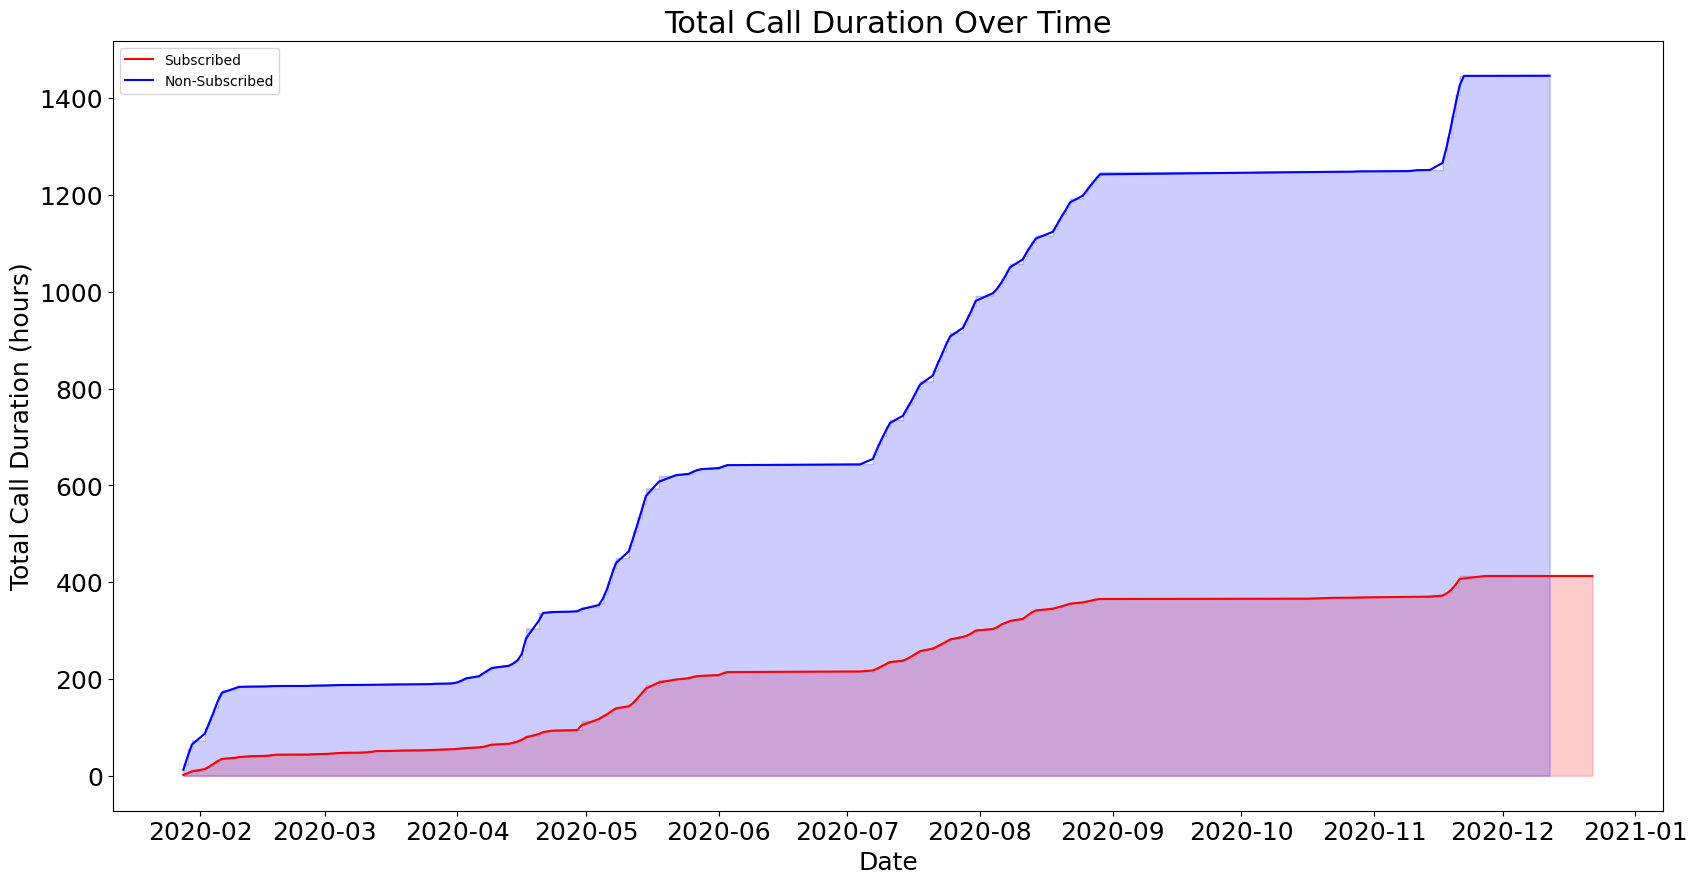

In [ ]:
subscribers = data_clean[data_clean['subscribed'] == 1]
non_subscribers = data_clean[data_clean['subscribed'] == 0]

plt.figure(figsize=(20, 10))
sns.lineplot(
    x=subscribers['date'],
    y=subscribers['duration'].cumsum()/(60*60),
    label='Subscribed',
    color='red'
)
plt.fill_between(
    subscribers['date'],
    subscribers['duration'].cumsum()/(60*60),
    alpha=0.2,
    color='red'
)
sns.lineplot(
    x=non_subscribers['date'],
    y=non_subscribers['duration'].cumsum()/(60*60),
    label='Non-Subscribed',
    color='blue'
)
plt.fill_between(
    non_subscribers['date'],
    non_subscribers['duration'].cumsum()/(60*60),
    alpha=0.2,
    color='blue'
)
plt.title('Total Call Duration Over Time', fontsize=22)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Total Call Duration (hours)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend()
plt.show()

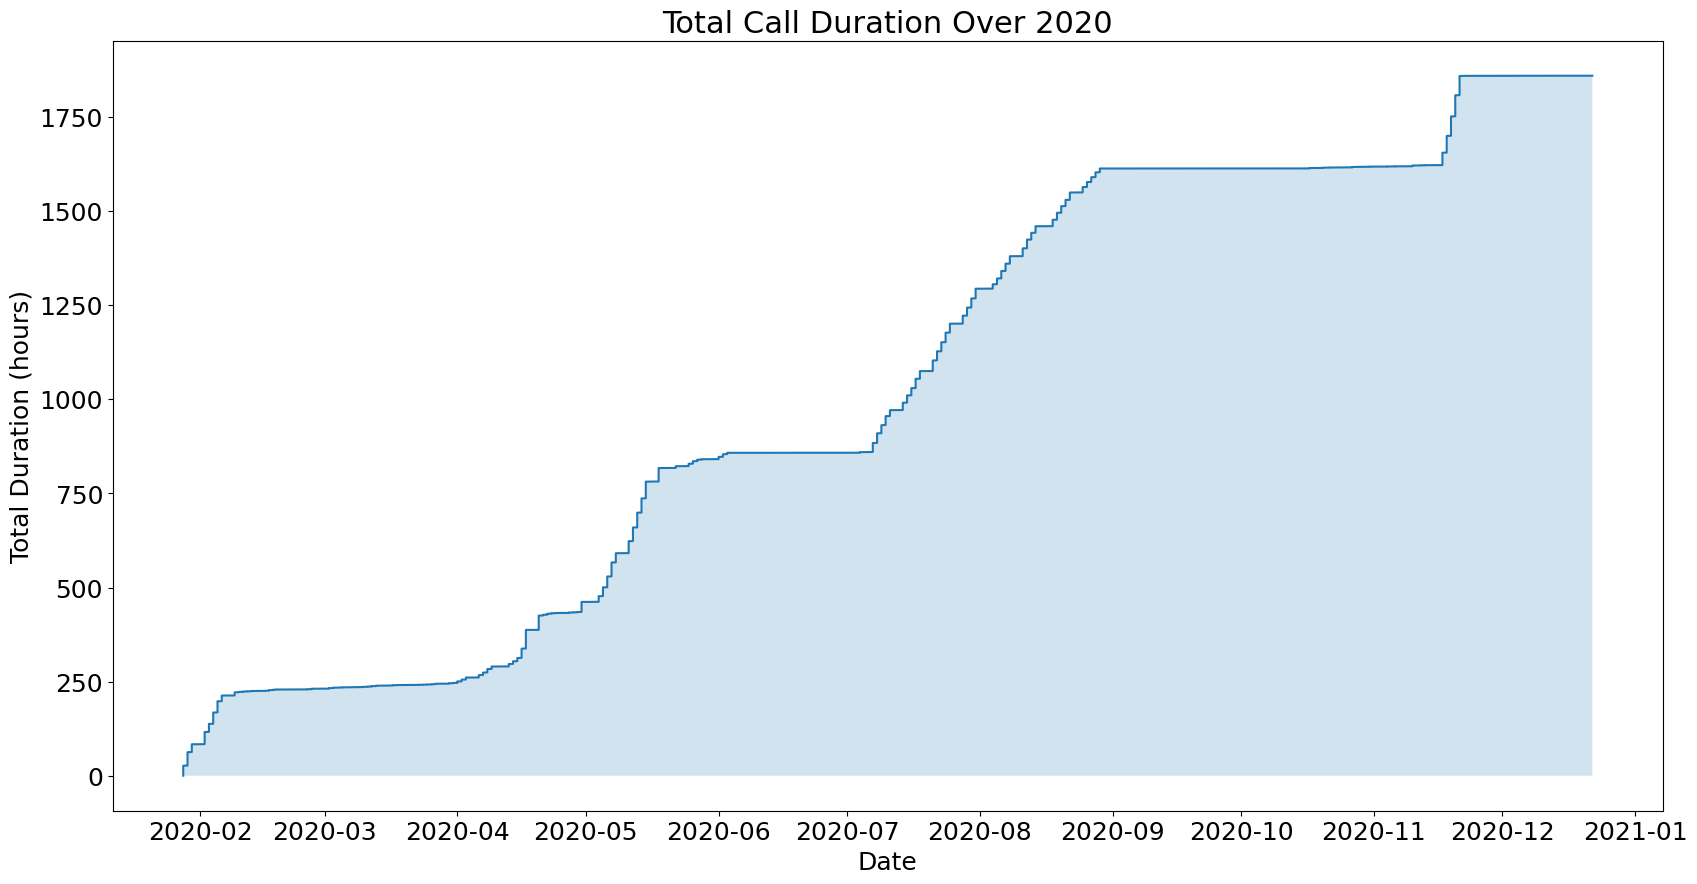

In [ ]:
plt.figure(figsize=(20,10))
plt.fill_between(
    data_clean['date'],
    data_clean['duration'].cumsum()/(60*60),
    alpha=0.2
)
plt.plot(
    data_clean['date'],
    data_clean['duration'].cumsum()/(60*60)
)
plt.title('Total Call Duration Over 2020', fontsize=22)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Total Duration (hours)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

From the plots above, we see that call centers spent around 1400 hours or about 78% of their time talking to people who did not subscribe to a term deposit. This suggests that they are not focusing their efforts efficiently.

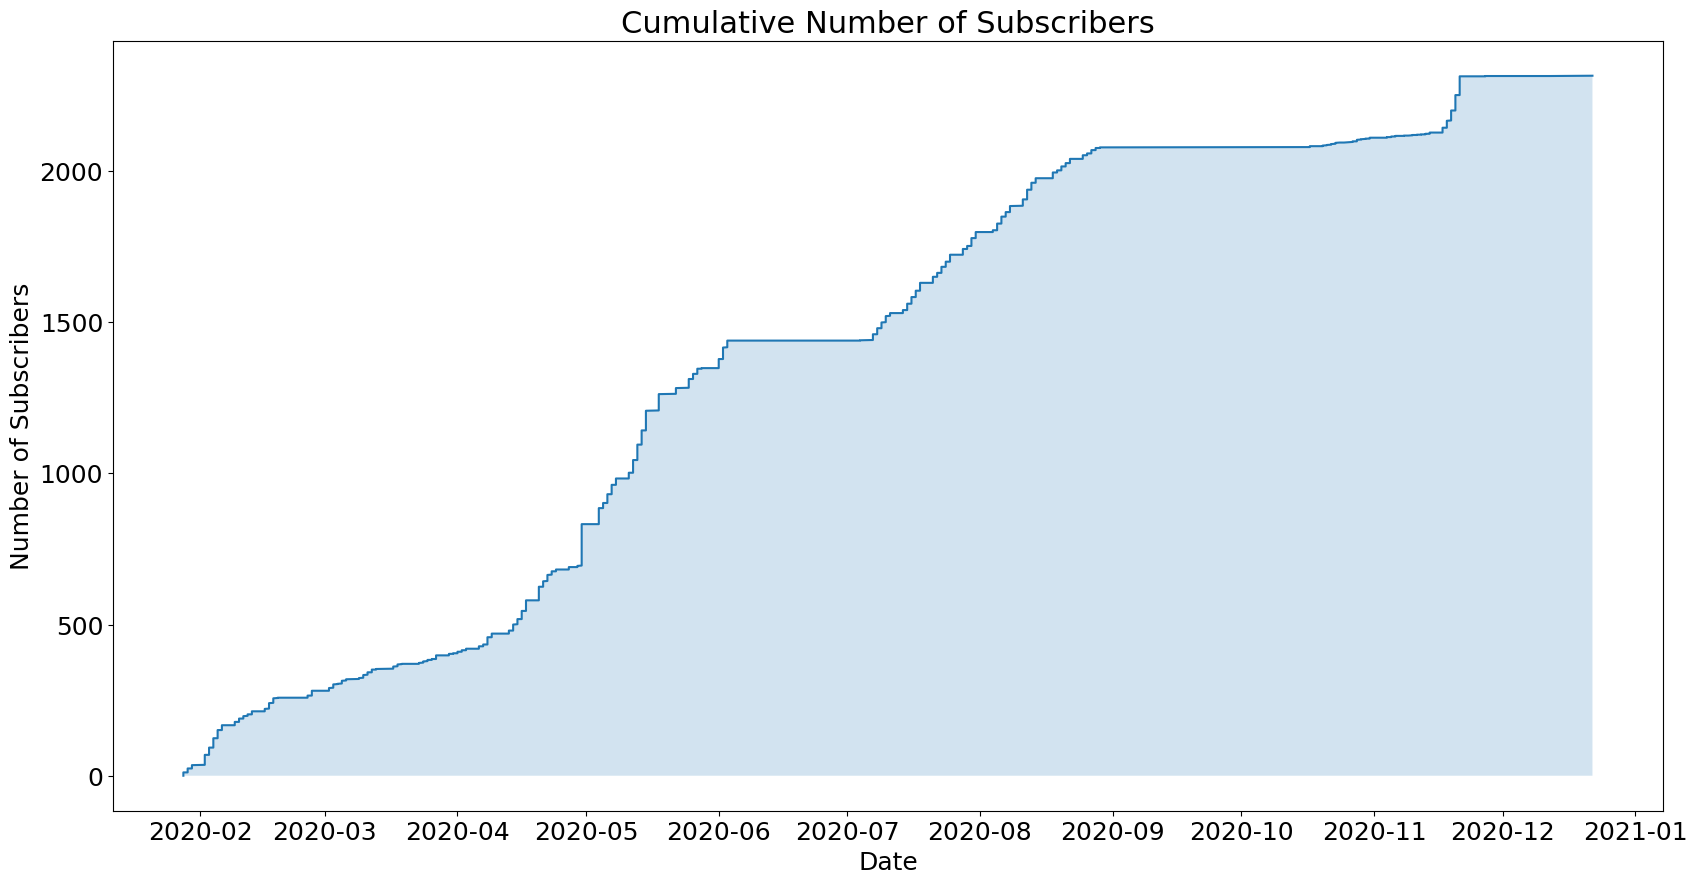

In [ ]:
plt.figure(figsize=(20,10))
plt.fill_between(
    data_clean['date'],
    data_clean['subscribed'].cumsum(),
    alpha=0.2
)
plt.plot(
    data_clean['date'],
    data_clean['subscribed'].cumsum()
)
plt.title('Cumulative Number of Subscribers' , fontsize=22)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number of Subscribers', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

From the plot above, we see that subscriber counts grew the fastest during the summer. This could be due to several factors such as market conditions, reduced expenses, or special offers.

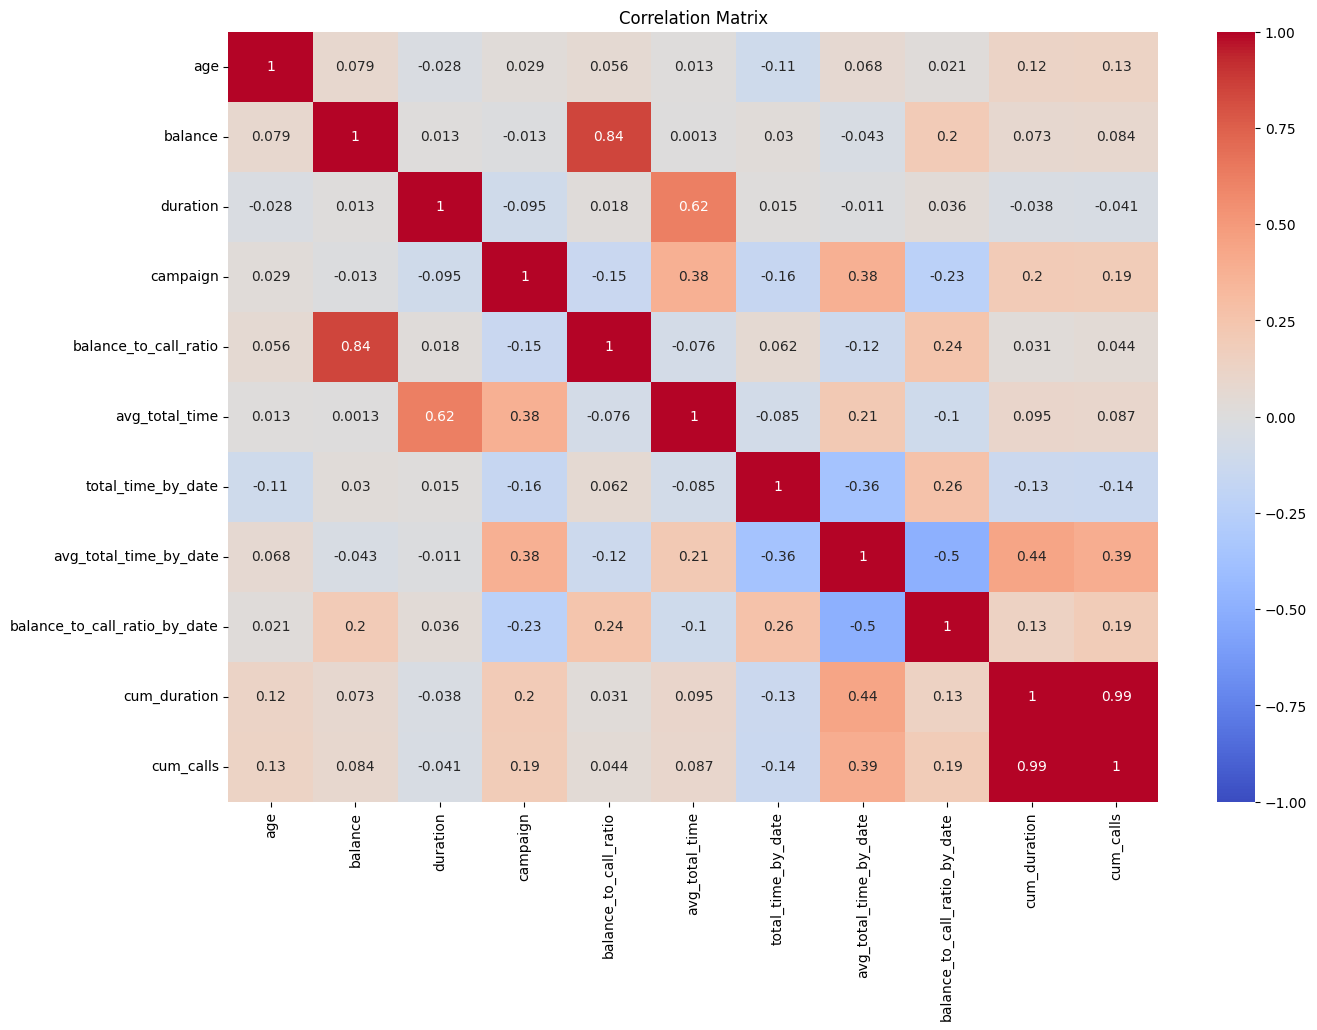

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(
    data_clean[num_cols].corr(),
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1
)
plt.title('Correlation Matrix')
plt.show()

From the plot above, we see that some of our features are highly correlated. To address this, we will apply feature selection to reduce the dimensionality of our dataset.

Now that we have explored our dataset, let us finally train our model.

## Model Training and Tuning

In [ ]:
features = list(set(data_clean.columns) - set(['date', 'subscribed']))
target = 'subscribed'

X = data_clean[features]
y = data_clean[target]

cat_cols = ['job', 'education', 'contact', 'marital']

########################################### PREPROCESSING PIPELINES ###########################################

num_transformer = Pipeline(
    steps=[
        (
            'yeo_johnson',
            PowerTransformer(
                method='yeo-johnson', # normalizes our numeric features
                standardize=False
            )
        ),
        (
            'spline',
            SplineTransformer(
                degree=2, # applies a spline transformation to our numeric features to help our model uncover more complex relationships
                n_knots=3
            )
        ),
        (
            'scaler',
            RobustScaler(
                quantile_range=(1.0, 99.0) # applies a robust scaler to our numeric features to help our model better handle outliers
            )
        ),
        (
            'selector',
            VarianceThreshold(
                threshold=0.05 # removes features with low variance
            )
        )
    ]
)

cat_transformer = Pipeline(
    steps=[
        (
            'ohe',
            OneHotEncoder(
                handle_unknown='ignore',
                sparse=False
            )
        ),
        (
            'selector',
            VarianceThreshold(
                threshold=0.05
            )
        )
    ]
)

smote = SMOTE(
    sampling_strategy='minority', # resamples the minority class
    random_state=42
)

preprocessor = ColumnTransformer(
    transformers=[
        (
            'cat',
            cat_transformer,
            cat_cols
        ),
        (
            'num',
            num_transformer,
            num_cols
        ),
    ],
    remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

preprocessor.fit(X_train, y_train)

X_train_preprocessed = pd.DataFrame(
    preprocessor.transform(X_train),
    columns=preprocessor.get_feature_names_out()
)
X_test_preprocessed = pd.DataFrame(
    preprocessor.transform(X_test),
    columns=preprocessor.get_feature_names_out()
)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test_preprocessed, y_test)


################################################# SET UP DMATRICES #####################################

dtrain = xgb.DMatrix(
    X_train_resampled,
    label=y_train_resampled
)

dtest = xgb.DMatrix(
    X_test_resampled,
    label=y_test_resampled
)

################################################ MODEL TRAINING #########################################

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 42
}

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    verbose_eval=100,
    callbacks=[
        # early stopping callback to prevent overfitting
        xgb.callback.EarlyStopping(
            rounds=300,
            metric_name='logloss',
            maximize=False,
            save_best=True
        )
    ]
)



[0]	train-logloss:0.51518	test-logloss:0.51889
[100]	train-logloss:0.04308	test-logloss:0.11026
[200]	train-logloss:0.02341	test-logloss:0.11939
[300]	train-logloss:0.01393	test-logloss:0.12801
[376]	train-logloss:0.01020	test-logloss:0.13692


## Model Evaluation

In [ ]:
y_prob = bst.predict(dtest)
y_pred = (y_prob > 0.5).astype(int)

metrics = {
    'accuracy': accuracy_score(y_test_resampled, y_pred),
    'precision': precision_score(y_test_resampled, y_pred),
    'recall': recall_score(y_test_resampled, y_pred),
    'f1': f1_score(y_test_resampled, y_pred),
    'roc_auc': roc_auc_score(y_test_resampled, y_pred)
}

metrics

{'accuracy': 0.9529816513761468,
 'precision': 0.9601779284049989,
 'recall': 0.945162635529608,
 'f1': 0.9526111169486183,
 'roc_auc': 0.9529816513761468}

We see that our model has exceptional performance. Now let us plot the feature importances of our model, along with a swarm plot of SHAP values to uncover more insights.

<Figure size 640x480 with 0 Axes>

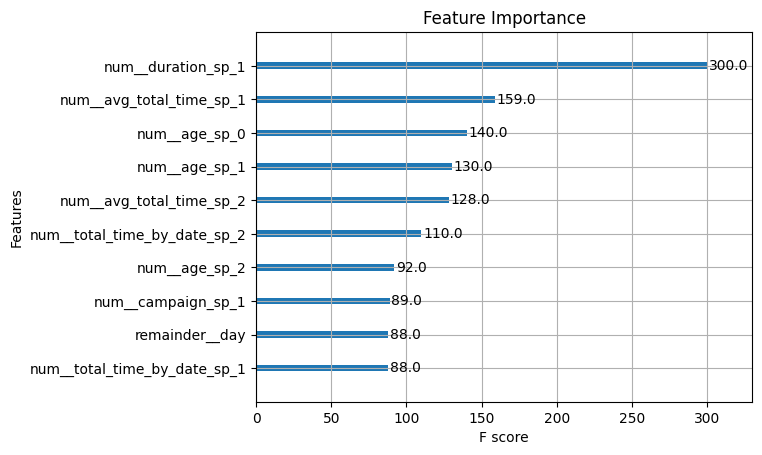

In [ ]:
plt.figure()
xgb.plot_importance(bst, max_num_features=10)
plt.title('Feature Importance')
plt.show()

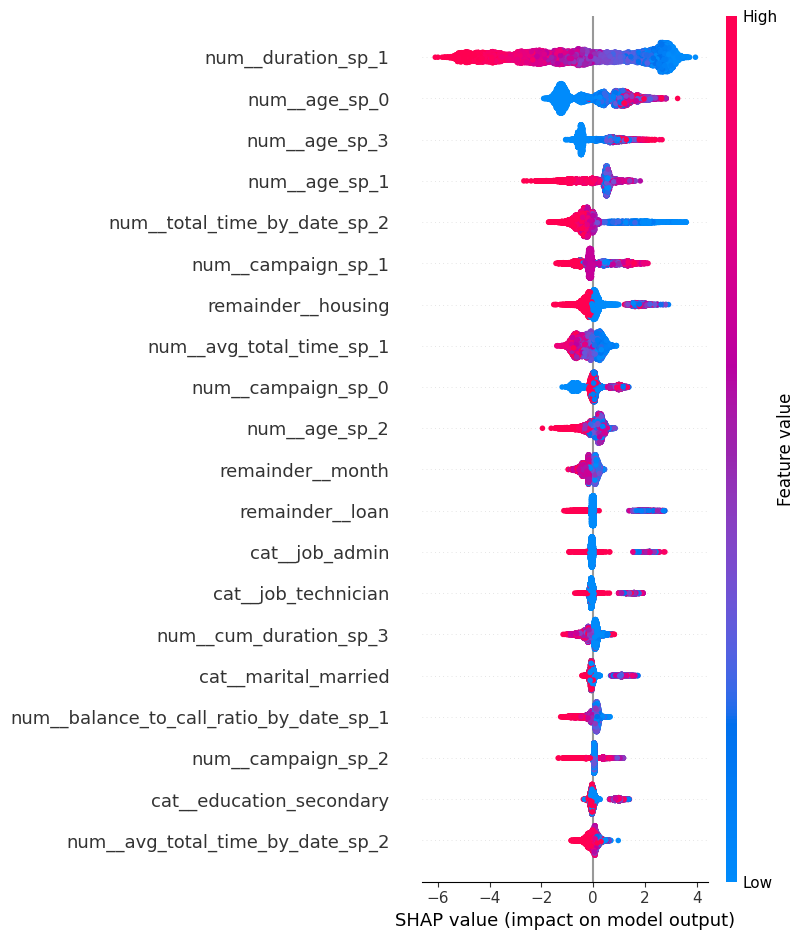

In [ ]:
import shap

explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test_resampled)

shap.summary_plot(shap_values, X_test_resampled)

In the plots above, we see that our spline features are not very interpretable. However, we see that duration, age, and the time of the year play a substantial role in predicting the probability of a client subscribing to a term deposit.

## Conclusion and Recommendations to Business

In the future, I recommend that call centers should:

- Focus their efforts on people who are married, educated, and have disposable income, seeking further finiancial stability.
- Offer special deals during the summer to further incentivize such people to subscribe.

Adopting these strategies, they will save hundreds of wasted hours a year and spend more time on calling clients far more likely to subscribe.

